import numpy as np

In [106]:
import skimage.transform

In [48]:
from PIL import Image

In [2]:
import bioimageio.core

site.config.json: 6.38kiB [00:00, 3.46MiB/s]                                                          
/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (6377) does not have expected size (2232).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
collection.json: 201kiB [00:00, 56.0MiB/s]                                                            
/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (200741) does not have expected size (24933).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")


In [85]:
import zarr
import dask.array as da

def remote_zarr_to_model_input(ome_zarr_uri):
    """Makes many bad assumptions about shape."""
    
    zgroup = zarr.open(ome_zarr_uri)
    zarray = zgroup['0']    

    darray = da.from_zarr(zarray)

    return darray

def scale_to_uint8(array):
    """Given an input array, convert to uint8, including scaling to fill the
    0-255 range.

    Primarily used to convert general numpy arrays into an image rendering
    suitable dtype."""

    scaled = array.astype(np.float32)

    if scaled.max() - scaled.min() == 0:
        return np.zeros(array.shape, dtype=np.uint8)

    scaled = 255 * (scaled - scaled.min()) / (scaled.max() - scaled.min())

    return scaled.astype(np.uint8)

In [44]:
import napari 
def show_images(*images, names=None):
    v = napari.Viewer()
    for i, im  in enumerate(images):
        name = None if names is None else names[i]
        if isinstance(im, str):
            im = imageio.imread(im)
        v.add_image(im, name=name)

In [10]:
rdf_doi = "10.5281/zenodo.6348084/6348085" # Stardist fluorescence

In [11]:
model_resource = bioimageio.core.load_resource_description(rdf_doi)

rdf.yaml: 5.37kiB [00:00, 2.08MiB/s]                                                                  
/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (5374) does not have expected size (1922).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
stardist_postprocessing.ijm: 100%|██████████████████████████████| 1.82k/1.82k [00:00<00:00, 1.94MiB/s]
stardist_weights.h5: 100%|██████████████████████████████████████| 5.77M/5.77M [00:00<00:00, 18.8MiB/s]
per_sample_scale_range.ijm: 100%|███████████████████████████████| 4.36k/4.36k [00:00<00:00, 1.64MiB/s]
stardist_logo.jpg: 100%|████████████████████████████████████████| 89.1k/89.1k [00:00<00:00, 1.88MiB/s]
example_fluo.jpg: 100%|█████████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 2.41MiB/s]
README.md: 100%|█████████████████████████████████████████████████████| 753/753 [00:00<00:00, 321kiB/s]
sample_input_0.tif

In [12]:
model_resource.name

'StarDist Fluorescence Nuclei Segmentation'

In [16]:
input_zarr_uri = "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD634/05e66f0c-d0a5-4198-b0ae-09f4b738d2fa/05e66f0c-d0a5-4198-b0ae-09f4b738d2fa.zarr/0"

In [17]:
remote_zarr_to_model_input(input_zarr_uri)

dask.array<from-zarr, shape=(1, 1, 1, 1024, 1280), dtype=uint8, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

In [20]:
prediction_pipeline = bioimageio.core.create_prediction_pipeline(
    model_resource
)

computing dataset statistics: 0it [00:00, ?it/s]


In [21]:
model_resource.inputs[0].axes

('b', 'y', 'x', 'c')

In [22]:
import xarray as xr

In [27]:
input_image = np.load(model_resource.test_inputs[0])

In [28]:
input_image.shape

(1, 384, 384, 1)

In [29]:
input_array = xr.DataArray(input_image, dims=tuple(model_resource.inputs[0].axes))

In [30]:
input_array.shape

(1, 384, 384, 1)

## The demo

In [33]:
rdf_doi = "10.5281/zenodo.6287342"

In [34]:
model_resource = bioimageio.core.load_resource_description(rdf_doi)

/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'framework': ['tensorflow', 'pytorch', 'tensorflow.js']}, {'software': ['ilastik', 'imagej', 'fiji', 'imjoy', 'deepimagej', 'n2v']}]
  warnings.warn(msg, category=ValidationWarning)
/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: weights:torchscript: missing 'pytorch_version'
  warnings.warn(msg, category=ValidationWarning)


In [35]:
from bioimageio.core.resource_tests import test_model
test_result = test_model(model_resource)

computing dataset statistics: 0it [00:00, ?it/s]


In [37]:
input_image = np.load(model_resource.test_inputs[0])

In [38]:
input_array = xr.DataArray(input_image, dims=tuple(model_resource.inputs[0].axes))

In [39]:
devices = None
weight_format = None

prediction_pipeline = bioimageio.core.create_prediction_pipeline(
    model_resource, devices=devices, weight_format=weight_format
)

computing dataset statistics: 0it [00:00, ?it/s]


In [45]:
prediction = prediction_pipeline(input_array)[0]
show_images(input_image, prediction, names=["image", "prediction"])  # show the prediction result

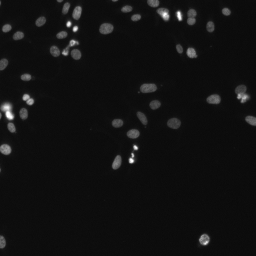

In [50]:
Image.fromarray(input_image[0,0,:,:,])

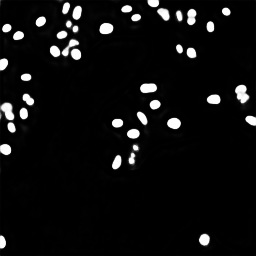

In [89]:
Image.fromarray(scale_to_uint8(prediction[0,0,:,:].to_numpy()))

In [51]:
ome_zarr_uri = "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD623/040082a9-1c26-4cc6-bd9a-e60043cf9e6a/040082a9-1c26-4cc6-bd9a-e60043cf9e6a.zarr/0"

In [68]:
ome_zarr_uri = "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD634/019da5bd-f6b3-445a-b9c7-0f0363133e34/019da5bd-f6b3-445a-b9c7-0f0363133e34.zarr/0"

In [69]:
dask_array = remote_zarr_to_model_input(ome_zarr_uri)

In [76]:
def show_the_damn_thing(input_array):
    if len(input_array.shape) == 5:
        array = input_array[0,:,0,:,:]

    if array.shape[0] == 1:
        return Image.fromarray(array.compute())

In [95]:
new_np_array = dask_array[0,0,0,:,:].compute()

In [107]:
resized = skimage.transform.resize(new_np_array, (256, 256))

In [108]:
right_dims = np.expand_dims(resized, (0, 1))

In [109]:
new_input_array = xr.DataArray(right_dims, dims=tuple(model_resource.inputs[0].axes))

In [110]:
prediction = prediction_pipeline(new_input_array)[0]

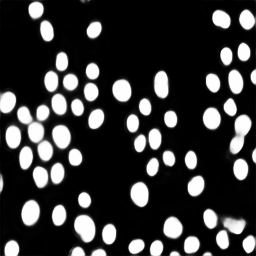

In [115]:
Image.fromarray(scale_to_uint8(prediction[0,0,:,:].to_numpy()))

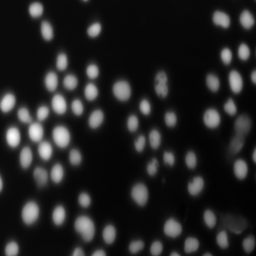

In [113]:
Image.fromarray(scale_to_uint8(resized))

In [116]:
import asyncio
import subprocess
import io

from PIL import Image
import numpy as np
from pyotritonclient import execute
from kaibu_utils import fetch_image

<xarray.DataArray (b: 1, c: 1, y: 256, x: 256)>
array([[[[0.12118591, 0.12097317, 0.12060796, ..., 0.1545878 ,
          0.17979701, 0.21580593],
         [0.12012409, 0.11931273, 0.11996874, ..., 0.14375223,
          0.1617176 , 0.18601015],
         [0.11906443, 0.12036771, 0.11932743, ..., 0.13429454,
          0.14634535, 0.16336519],
         ...,
         [0.13131595, 0.14251561, 0.16151218, ..., 0.10256137,
          0.09568845, 0.09090677],
         [0.1307402 , 0.14238594, 0.15889797, ..., 0.09716044,
          0.09184694, 0.0884713 ],
         [0.13041197, 0.14091888, 0.15555052, ..., 0.09428564,
          0.08940108, 0.08673587]]]], dtype=float32)
Dimensions without coordinates: b, c, y, x

## Let's do mitochondria

In [176]:
rdf_doi = "10.5281/zenodo.6406803"

In [177]:
model_resource = bioimageio.core.load_resource_description(rdf_doi)

/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'framework': ['tensorflow', 'pytorch', 'tensorflow.js']}, {'software': ['ilastik', 'imagej', 'fiji', 'imjoy', 'deepimagej', 'n2v']}]
  warnings.warn(msg, category=ValidationWarning)
/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: weights:torchscript: missing 'pytorch_version'
  warnings.warn(msg, category=ValidationWarning)


In [126]:
test_result = test_model(model_resource)

computing dataset statistics: 0it [00:00, ?it/s]


In [162]:
test_result

[{'name': 'load resource description',
  'status': 'passed',
  'error': None,
  'nested_errors': None,
  'traceback': None,
  'bioimageio_spec_version': '0.4.9post5',
  'bioimageio_core_version': '0.5.11',
  'warnings': {},
  'source_name': '10.5281/zenodo.6406803/6406804'},
 {'name': 'has expected resource type',
  'status': 'passed',
  'error': None,
  'traceback': None,
  'source_name': '10.5281/zenodo.6406803/6406804'},
 {'name': 'All URLs and paths available',
  'status': 'passed',
  'error': None,
  'traceback': None,
  'bioimageio_spec_version': '0.4.9post5',
  'bioimageio_core_version': '0.5.11',
  'nested_errors': None,
  'source_name': '10.5281/zenodo.6406803/6406804',
  'warnings': {}},
 {'name': 'Test documentation completeness.',
  'status': 'passed',
  'error': None,
  'traceback': None,
  'bioimageio_spec_version': '0.4.9post5',
  'bioimageio_core_version': '0.5.11',
  'source_name': '10.5281/zenodo.6406803/6406804',
  'warnings': {'documentation': "No '# Validation' (su

In [127]:
model_resource.inputs[0].axes

('b', 'c', 'y', 'x')

In [178]:
input_image = np.load(model_resource.test_inputs[0])

In [179]:
input_image.shape

(1, 1, 512, 512)

In [180]:
input_image.dtype

dtype('uint8')

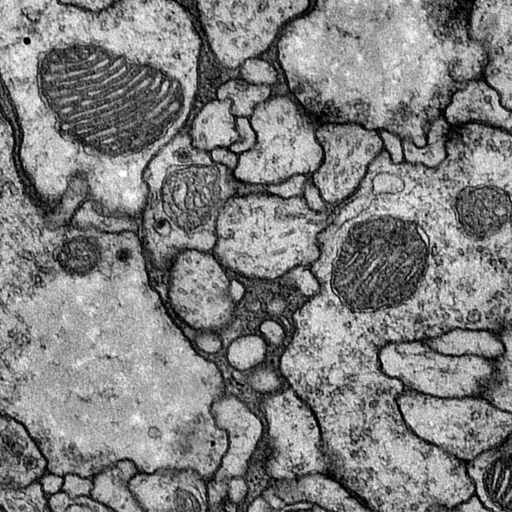

In [133]:
Image.fromarray(scale_to_uint8(input_image[0,0,:,:]))

In [134]:
ome_zarr_uri = "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/EMPIAR-10311/IM1/IM1.zarr/0"

In [189]:
import dask.array as da
def remote_zarr_to_model_input(ome_zarr_uri):
    """Makes many bad assumptions about shape."""
    
    zgroup = zarr.open(ome_zarr_uri)
    zarray = zgroup['0']    

    darray = da.from_zarr(zarray)

    return darray

In [ ]:
da = remote_zarr_to_model_input(ome_zarr_uri)
inp = da[0, 0, 863, 300:812, 3000:3512].compute()

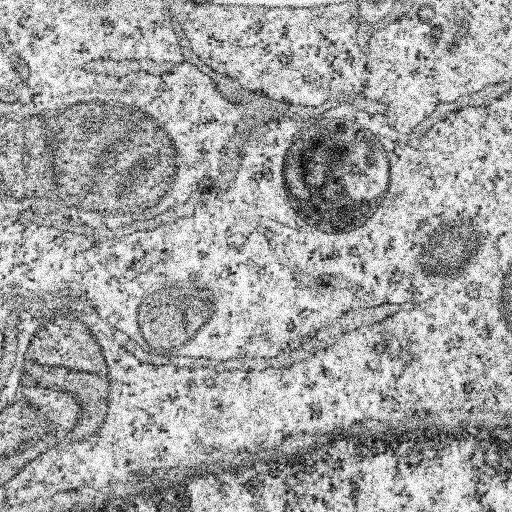

In [145]:
Image.fromarray(inp)

In [149]:
inp_right_dims = np.expand_dims(inp, (0, 1))

In [164]:
inp_right_dims.shape

(1, 1, 512, 512)

In [181]:
input_xarray = xr.DataArray(input_image, dims=tuple(model_resource.inputs[0].axes))

In [182]:
prediction_pipeline = bioimageio.core.create_prediction_pipeline(
    model_resource, devices=devices, weight_format=weight_format
)

computing dataset statistics: 0it [00:00, ?it/s]


In [186]:
result = prediction_pipeline.predict(input_xarray.astype('float32'))

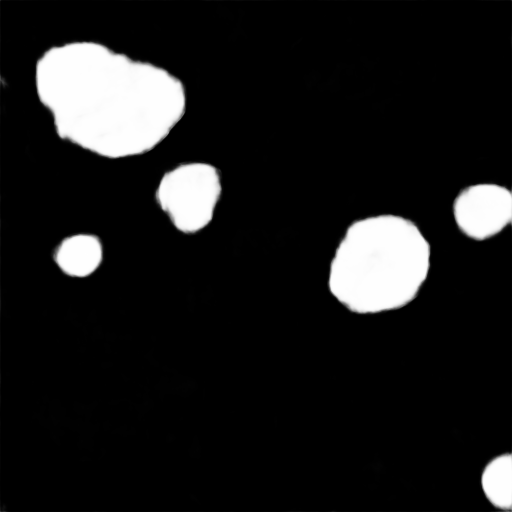

In [187]:
Image.fromarray(scale_to_uint8(result[0][0,0,:,:].to_numpy()))

In [190]:
da = remote_zarr_to_model_input(ome_zarr_uri)
inp = da[0, 0, 863, 300:812, 3000:3512].compute()

In [191]:
inp_right_dims = np.expand_dims(inp, (0, 1))

In [193]:
input_xarray = xr.DataArray(inp_right_dims, dims=tuple(model_resource.inputs[0].axes))

In [194]:
result = prediction_pipeline.predict(input_xarray.astype('float32'))

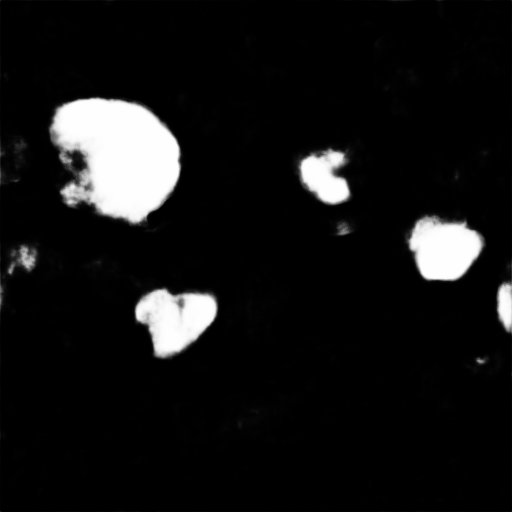

In [195]:
Image.fromarray(scale_to_uint8(result[0][0,0,:,:].to_numpy()))

## Maybe 3D is easier?!

In [196]:
rdf_doi = "10.5281/zenodo.5874841"

In [197]:
model_resource = bioimageio.core.load_resource_description(rdf_doi)

/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'framework': ['tensorflow', 'pytorch', 'tensorflow.js']}, {'software': ['ilastik', 'imagej', 'fiji', 'imjoy', 'deepimagej', 'n2v']}]
  warnings.warn(msg, category=ValidationWarning)
/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: weights:pytorch_state_dict: missing 'pytorch_version'
  warnings.warn(msg, category=ValidationWarning)
/Users/matthewh/.pyenv/versions/3.11.0/lib/python3.11/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: weights:torchscript: missing 'pytorch_version'
  warnings.warn(msg, category=ValidationWarning)


In [166]:
model_resource.inputs

[InputTensor(name='input0', data_type='uint8', axes=('b', 'c', 'z', 'y', 'x'), shape=ParametrizedInputShape(min=[1, 1, 8, 32, 32], step=[0, 0, 4, 16, 16]), preprocessing=[Preprocessing(name='zero_mean_unit_variance', kwargs={'axes': 'czyx', 'mode': 'per_sample'})], description=<marshmallow.missing>, data_range=(0.0, 255.0))]

In [198]:
inp = da[0, 0, 863:871, 300:332, 3000:3032].compute()

In [199]:
inp_right_dims = np.expand_dims(inp, (0, 1))

In [200]:
inp_right_dims.shape

(1, 1, 8, 32, 32)

In [201]:
input_xarray = xr.DataArray(inp_right_dims, dims=tuple(model_resource.inputs[0].axes))

In [202]:
prediction_pipeline = bioimageio.core.create_prediction_pipeline(
    model_resource, devices=devices, weight_format=weight_format
)

computing dataset statistics: 0it [00:00, ?it/s]


In [205]:
result = prediction_pipeline.predict(input_xarray.astype('float32'))